<a href="https://colab.research.google.com/github/juliacsds/CityScape/blob/main/mlproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting The Cost of a One-Bedroom Apartment in Major World Cities

First, let's read in our dataset. This was obtained from: https://www.kaggle.com/datasets/mvieira101/global-cost-of-living?resource=download



In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from google.colab import files
uploaded = files.upload()

Saving cost-of-living_v2.csv to cost-of-living_v2 (1).csv


In [ ]:
data = pd.read_csv('cost-of-living_v2.csv')
data.columns = ['city', 'country', 'meal_inexpensive', 'meal_midrange',
                'mcdonalds',
                'beer_domestic_restaurant', 'beer_imported_restaurant',
                'capuccino', 'coke', 'water_restaurant', 'milk', 'bread',
                'rice', 'eggs', 'cheese', 'chicken_fillet', 'beef', 'apple',
                'banana', 'orange', 'tomato', 'potato', 'onion', 'lettuce',
                'water_market', 'wine', 'beer_domestic_market',
                'beer_imported_market', 'cigarettes', 'one_way_ticket',
                'monthly_pass', 'taxi_start', 'taxi_1km', 'taxi_hour',
                'gasoline', 'volkswagen_new', 'toyota_new', 'utilities_apt',
                'mobile_tariff', 'internet', 'fitness_club', 'tennis_court',
                'cinema', 'preschool_private', 'international_primary',
                'jeans', 'summer_dress', 'nike_shoes', 'leather_shoes',
                'apt_1bed_center', 'apt_1bed_outside', 'apt_3bed_center',
                'apt_3bed_outside', 'apt_center_sqm_price',
                'apt_outside_sqm_price', 'avg_monthly_salary',
                'mortgage_interest', 'data_quality']
print('Total Rows of Data:', len(data))
data.head()

Total Rows of Data: 4956


,city,country,meal_inexpensive,meal_midrange,mcdonalds,beer_domestic_restaurant,beer_imported_restaurant,capuccino,coke,water_restaurant,...,leather_shoes,apt_1bed_center,apt_1bed_outside,apt_3bed_center,apt_3bed_outside,apt_center_sqm_price,apt_outside_sqm_price,avg_monthly_salary,mortgage_interest,data_quality
0,Seoul,South Korea,7.68,53.78,6.15,3.07,4.99,3.93,1.48,0.79,...,110.36,742.54,557.52,2669.12,1731.08,22067.70,10971.90,2689.62,3.47,1
1,Shanghai,China,5.69,39.86,5.69,1.14,4.27,3.98,0.53,0.33,...,123.51,1091.93,569.88,2952.70,1561.59,17746.11,9416.35,1419.87,5.03,1
2,Guangzhou,China,4.13,28.47,4.98,0.85,1.71,3.54,0.44,0.33,...,43.89,533.28,317.45,1242.24,688.05,12892.82,5427.45,1211.68,5.19,1
3,Mumbai,India,3.68,18.42,3.68,2.46,4.30,2.48,0.48,0.19,...,41.17,522.40,294.05,1411.12,699.80,6092.45,2777.51,640.81,7.96,1
4,Delhi,India,4.91,22.11,4.30,1.84,3.68,1.77,0.49,0.19,...,36.50,229.84,135.31,601.02,329.15,2506.73,1036.74,586.46,8.06,1


# Data Preparation and Cleaning

First, let's examine the overall features and missing values in our dataset.

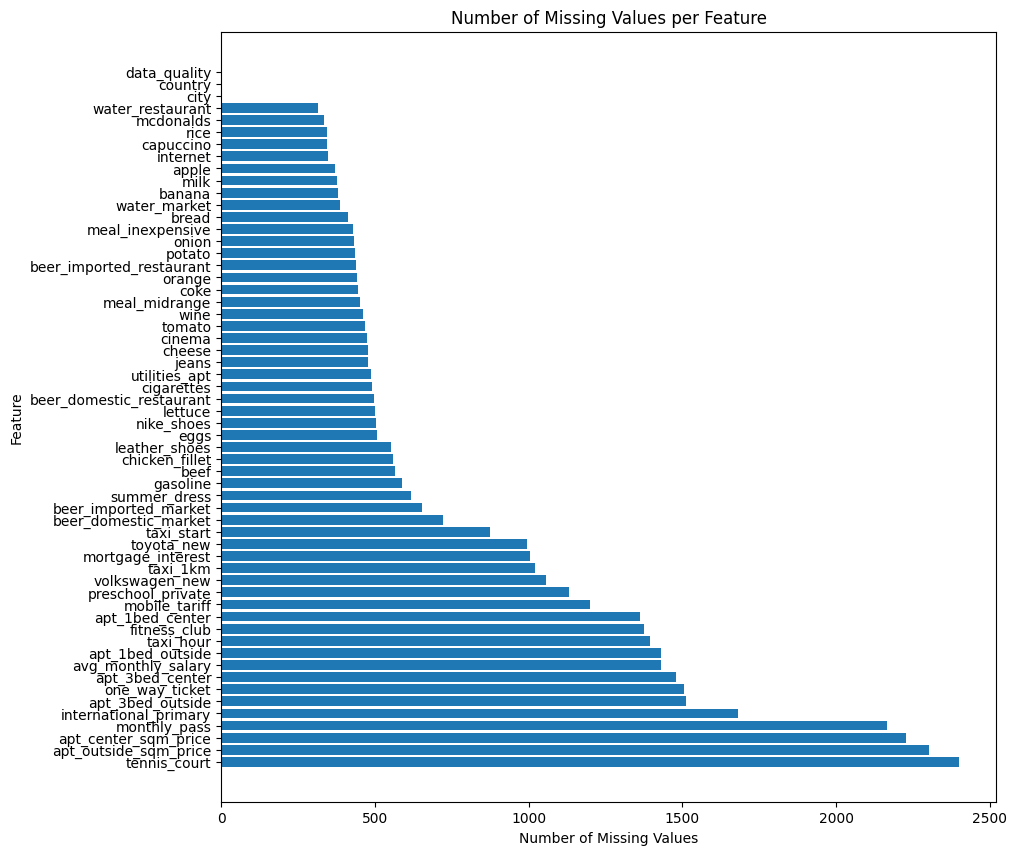

In [ ]:
missing = data.isnull().sum()
missing_sorted = missing.sort_values(ascending=False)
plt.rcParams['figure.figsize'] = [10, 10]
plt.title('Number of Missing Values per Feature')
plt.barh(missing_sorted.index, missing_sorted.values)
plt.ylabel('Feature')
plt.xlabel('Number of Missing Values')
plt.show()

We are trying to predict the **"apt_1bed_center"** feature, which is the price
of a one-bedroom apartment in the city center. So we can drop the features that are too closely correlated to our target feature--namely, the price of a 3
bedroom apartment inside our outside the city center, the price of a 1
bedroom apartment outside the city center, and the average price per square
meter of apartments inside or outside the city center. These are all too similar to what we're predicting.

Dropping these values is also good because they happen to be missing a lot of data in the original dataset. There are other features such as **"international_primary", "monthly_pass", and "tennis_court"** that also have high volumes of missing data that we might want to look out for when testing models, as if they aren't important features than dropping them could provide us with more data to work with.

The dataset contains a "data quality" column that identifies which records are considered to have good data quality by the creator. However, only keeping those rows for training yields just 744 records for training and testing, which is 15% of the original dataset size.

Thus, to have more data, we will focus on first dropping the unnecessary columns and then removing records with missing values, without worrying about data quality. We will test models on both this dataset and a smaller datset with only "good quality" records.

We can drop any rows with a missing value for any one of the features to clean up our data. This leaves us with 1427 records in the dataset to use for training/testing.

In [ ]:
# # For later use
# data_good_qual = data[data['data_quality'] != 0]
# Clean data
data_clean = data.drop(['apt_1bed_outside', 'apt_3bed_outside', 'apt_3bed_center',
                  'apt_center_sqm_price', 'apt_outside_sqm_price'], axis=1)
data_clean.dropna(inplace=True)
data_clean.drop_duplicates(inplace=True)
data_clean

,city,country,meal_inexpensive,meal_midrange,mcdonalds,beer_domestic_restaurant,beer_imported_restaurant,capuccino,coke,water_restaurant,...,preschool_private,international_primary,jeans,summer_dress,nike_shoes,leather_shoes,apt_1bed_center,avg_monthly_salary,mortgage_interest,data_quality
0,Seoul,South Korea,7.68,53.78,6.15,3.07,4.99,3.93,1.48,0.79,...,404.15,17902.55,58.26,46.36,70.81,110.36,742.54,2689.62,3.47,1
1,Shanghai,China,5.69,39.86,5.69,1.14,4.27,3.98,0.53,0.33,...,1382.62,26379.45,70.49,34.92,88.21,123.51,1091.93,1419.87,5.03,1
2,Guangzhou,China,4.13,28.47,4.98,0.85,1.71,3.54,0.44,0.33,...,555.18,24556.21,63.43,33.83,66.73,43.89,533.28,1211.68,5.19,1
3,Mumbai,India,3.68,18.42,3.68,2.46,4.30,2.48,0.48,0.19,...,107.07,3682.67,32.77,27.75,49.87,41.17,522.40,640.81,7.96,1
4,Delhi,India,4.91,22.11,4.30,1.84,3.68,1.77,0.49,0.19,...,74.00,1964.24,32.12,33.44,49.99,36.50,229.84,586.46,8.06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4826,Lysa nad Labem,Czech Republic,4.33,32.40,5.19,1.25,2.29,2.15,1.24,0.97,...,432.59,4325.86,64.89,25.91,98.74,73.50,605.62,634.46,7.00,0
4910,Livigno,Italy,14.23,52.69,7.38,3.42,4.21,1.50,2.50,0.53,...,94.84,3688.11,68.49,36.88,59.71,100.11,843.00,1580.62,1.30,0
4928,Murovani Kurylivtsi,Ukraine,2.72,12.24,2.69,0.68,1.09,0.68,0.24,0.14,...,167.71,1387.02,34.00,27.17,59.56,61.19,108.79,365.79,13.05,0
4945,Tirupati,India,2.46,9.21,4.30,2.21,3.07,1.47,0.46,0.14,...,36.85,1228.18,30.92,14.43,38.89,37.25,82.90,614.09,7.97,0


Next, we can look at which features are most closely correlated with the target variable (price of a 1 bed apartment in the city center)?

<ipython-input-40-12e42d0ea324>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_clean.corr(method=cur_method).abs()


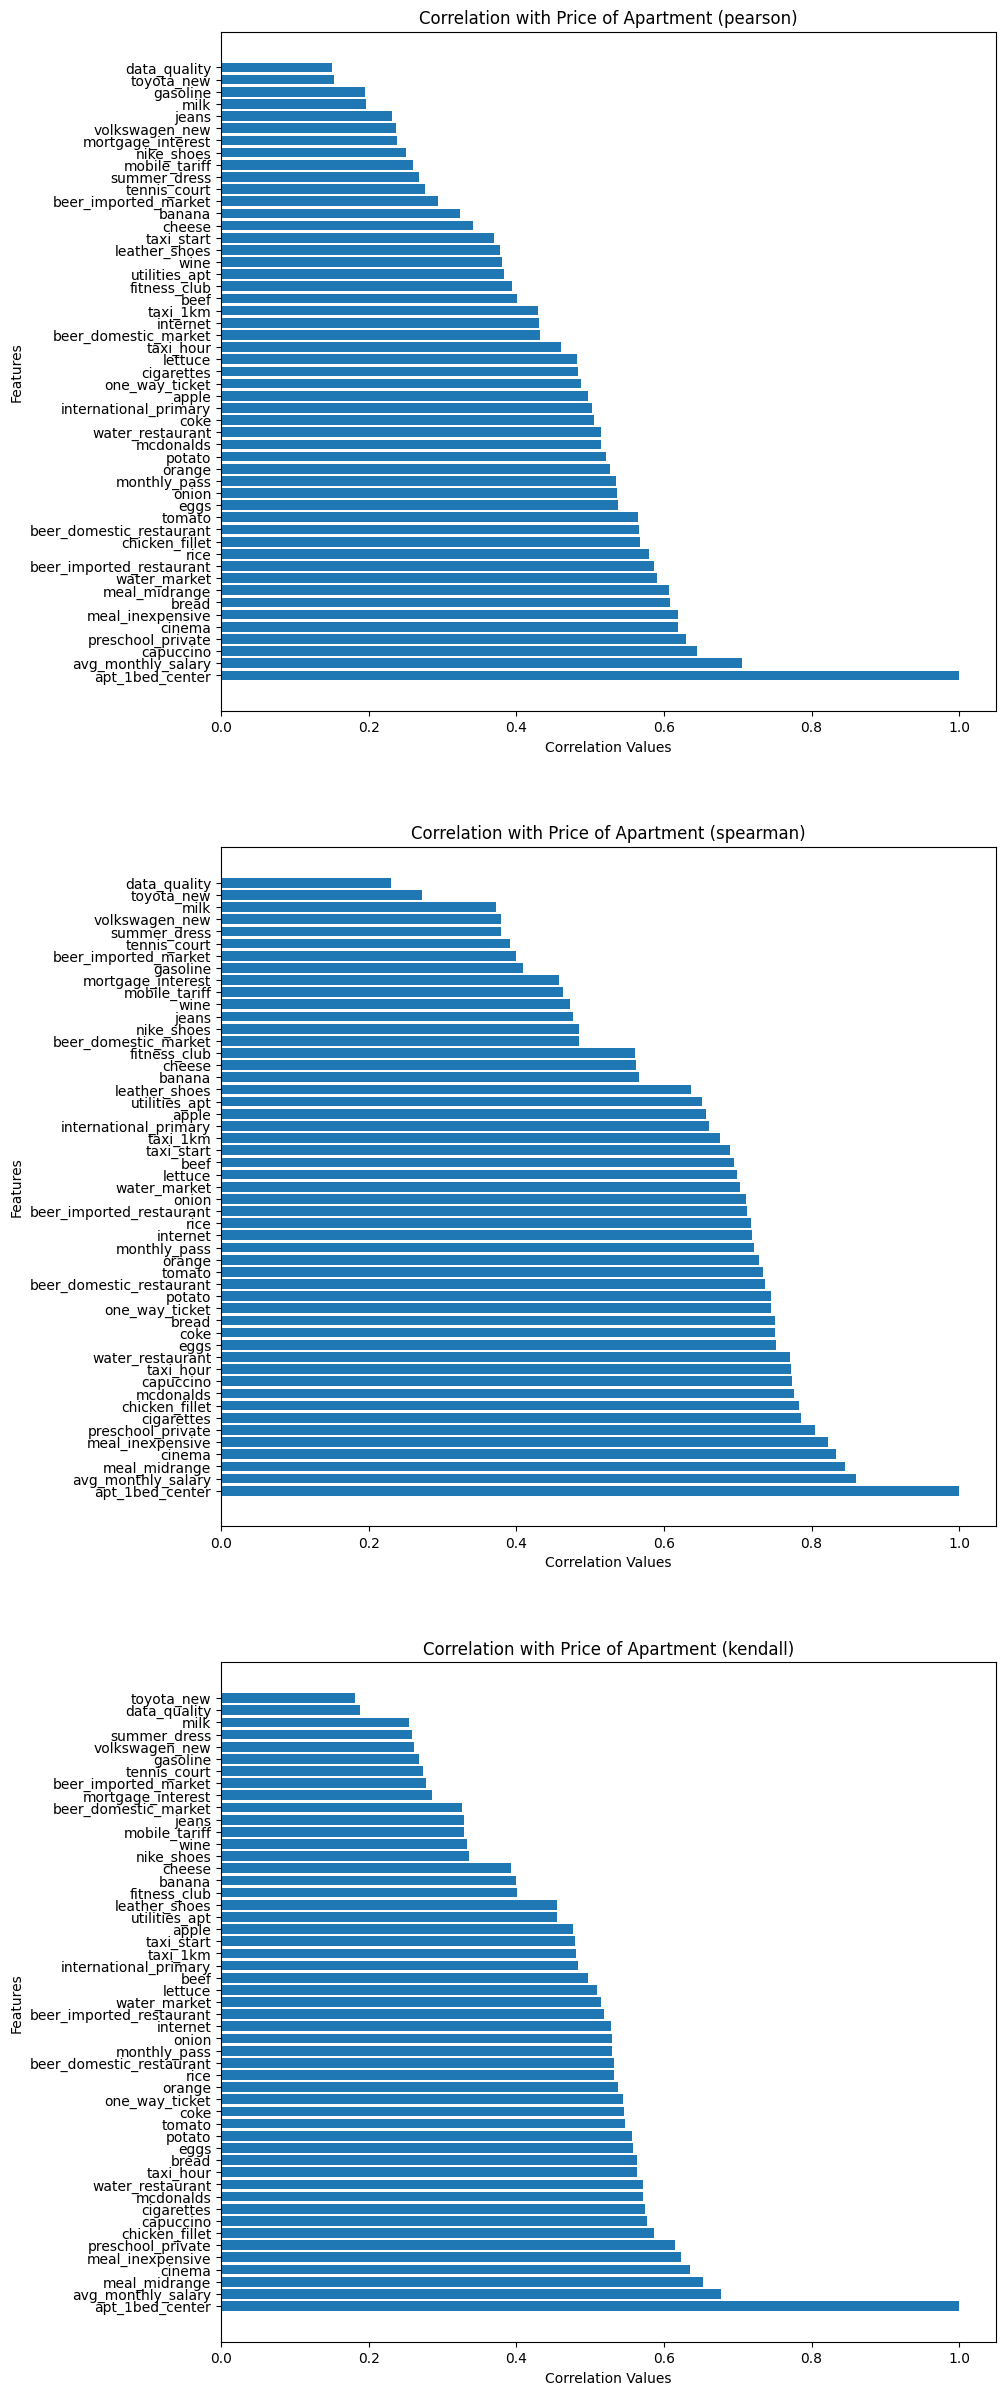

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplots_adjust(hspace=0.2)
# plt.suptitle("Correlations")

for i in range(3):
  cur_method = 'pearson'
  if i == 1:
    cur_method = 'spearman'
  elif i == 2:
    cur_method = 'kendall'
  corr = data_clean.corr(method=cur_method).abs()
  corr_y = corr['apt_1bed_center'].sort_values(ascending=False)

  ax = plt.subplot(3,1,i+1)
  ax.barh(corr_y.index, corr_y.values)
  ax.set_xlabel('Correlation Values')
  ax.set_ylabel('Features')
  ax.set_title('Correlation with Price of Apartment (' + cur_method + ')')

# Data Exploration

Based on these plots, average monthly salary, meal prices, and cinema prices seem to individually have a bigger correlation with our target feature.

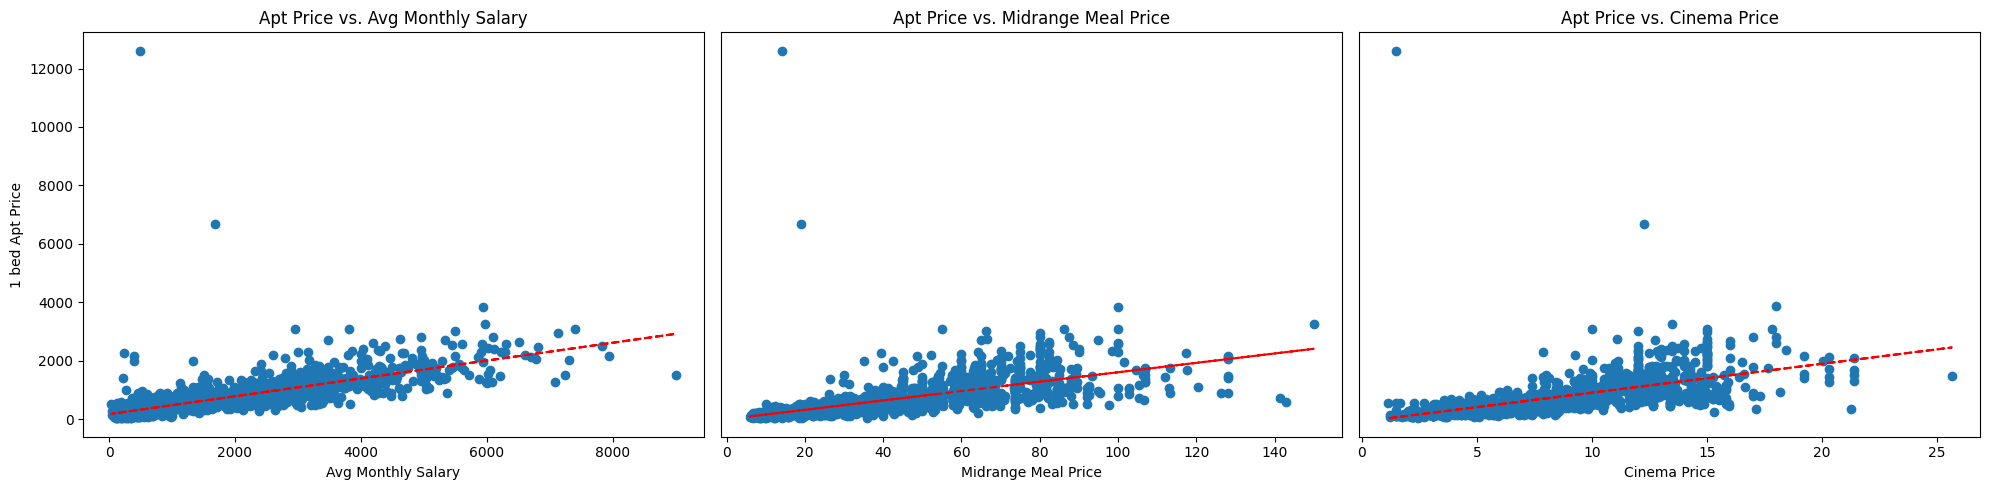

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
x = data_clean['avg_monthly_salary'].values
y = data_clean['apt_1bed_center'].values
plt.scatter(x,y)
a, b = np.polyfit(x,y, 1)
plt.plot(x, a*x+b, color='red', linestyle='--')
plt.ylabel('1 bed Apt Price')
plt.xlabel('Avg Monthly Salary')
plt.title('Apt Price vs. Avg Monthly Salary')

plt.subplot(1,3,2)
x = data_clean['meal_midrange'].values
plt.scatter(x,y)
a, b = np.polyfit(x,y, 1)
plt.plot(x, a*x+b, color='red', linestyle='--')
plt.xlabel('Midrange Meal Price')
plt.yticks([])
plt.title('Apt Price vs. Midrange Meal Price')

plt.subplot(1,3,3)
x = data_clean['cinema'].values
plt.scatter(x,y)
a, b = np.polyfit(x,y, 1)
plt.plot(x, a*x+b, color='red', linestyle='--')
plt.xlabel('Cinema Price')
plt.yticks([])
plt.title('Apt Price vs. Cinema Price')

plt.tight_layout()
plt.show()

What does the distribution of our target feature look like?

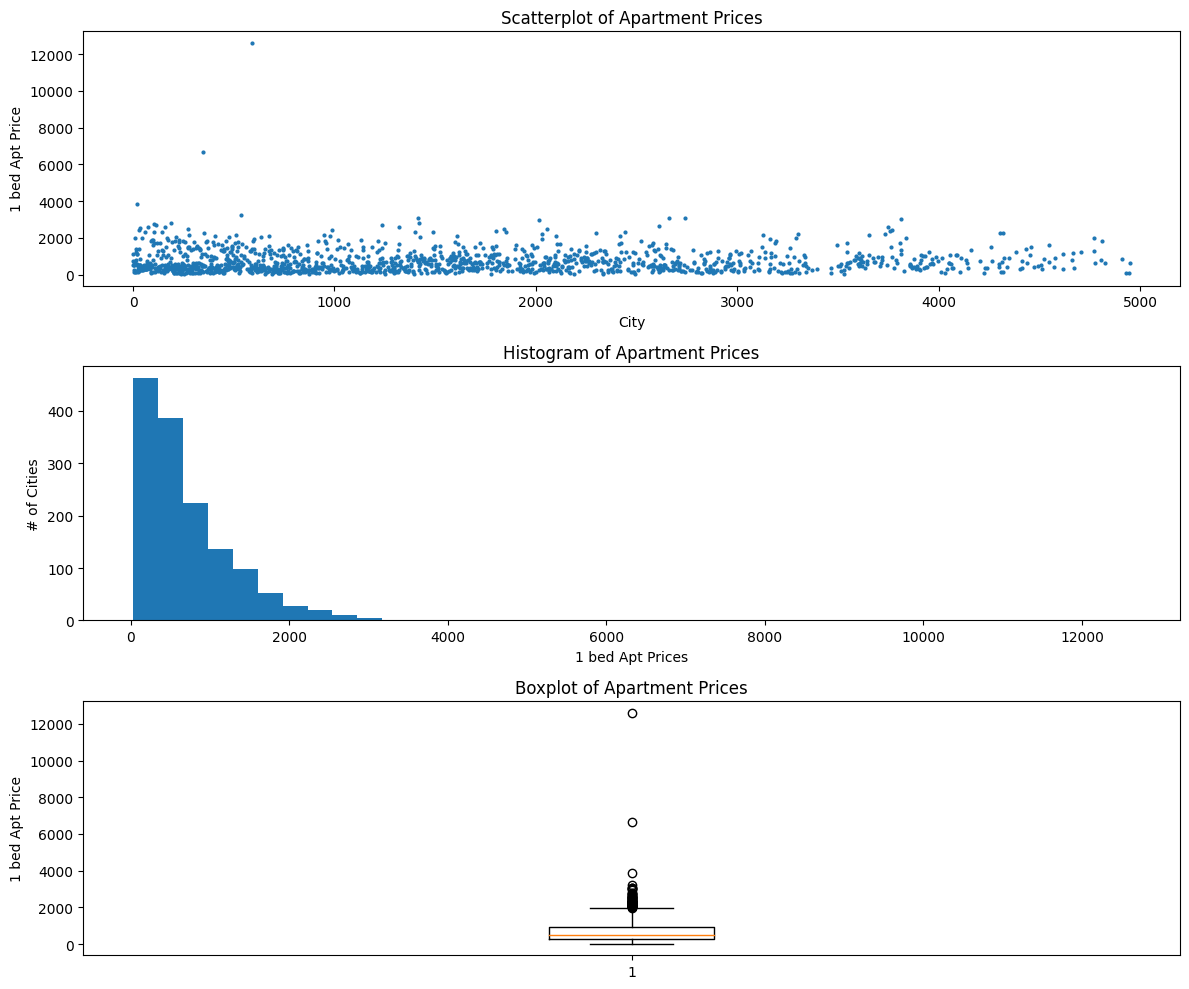

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(3,1,1)
data_sorted_apt = data_clean.sort_values(by=['apt_1bed_center'])
plt.scatter(data_sorted_apt.index, data_sorted_apt['apt_1bed_center'], s=4)
plt.xlabel('City')
plt.ylabel('1 bed Apt Price')
plt.title("Scatterplot of Apartment Prices")

plt.subplot(3,1,2)
plt.hist(data_clean['apt_1bed_center'], bins=40)
plt.xlabel('1 bed Apt Prices')
plt.ylabel('# of Cities')
plt.title("Histogram of Apartment Prices")

plt.subplot(3,1,3)
plt.boxplot(data_clean['apt_1bed_center'])
plt.ylabel('1 bed Apt Price')
plt.title("Boxplot of Apartment Prices")
plt.tight_layout()

# Anomaly Detection (Data Cleaning + Exploration)

While we've removed the missing values, there could be outliers in the data and removing them would be helpful for testing our models. We can clearly see from the plots above that there are some outliers that have extremely high values for the apartment price variable, which should probably be removed. We run anomaly detection with the isolation forest algorithm to find and specifically identify outliers like this. This algorithm is good for our purposes because it is fast, not susceptible to curse of dimensionality (we have many features in our dataset), and it does not require significant tuning of hyperparameters (only the anomaly threshold value to identify an anomaly).

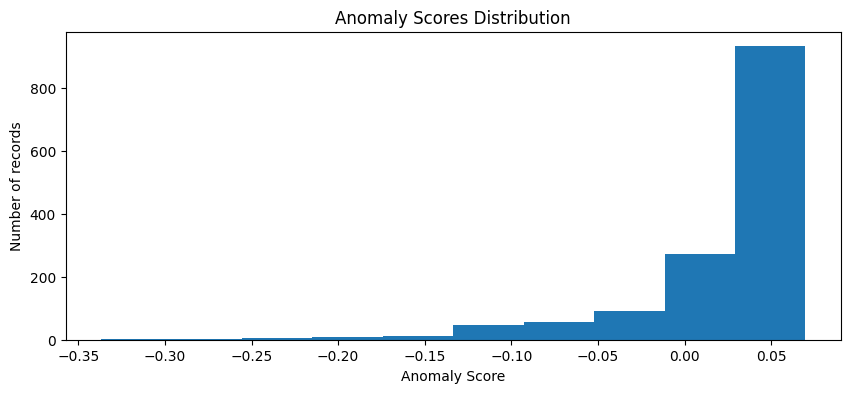

In [ ]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest()
isof.fit(data_clean[['apt_1bed_center']])
data_clean['anomaly_scores'] = isof.decision_function(
    data_clean[['apt_1bed_center']]
    )
plt.figure(figsize=(10,4))
plt.hist(data_clean['anomaly_scores'])
plt.xlabel('Anomaly Score')
plt.ylabel('Number of records')
plt.title('Anomaly Scores Distribution')
plt.show()

Create column for identifying anomalies.

In [ ]:
data_clean['anomaly'] = 1

We identify anomalies by using a cutoff score to identify normal vs. non-anomalous objects.

In [ ]:
cutoff = -0.15
anomalies = data_clean[data_clean['anomaly_scores'] < cutoff]
print('Number of Anomalous Data Points Found:', len(anomalies))
anomalies

Number of Anomalous Data Points Found: 27


,city,country,meal_inexpensive,meal_midrange,mcdonalds,beer_domestic_restaurant,beer_imported_restaurant,capuccino,coke,water_restaurant,...,jeans,summer_dress,nike_shoes,leather_shoes,apt_1bed_center,avg_monthly_salary,mortgage_interest,data_quality,anomaly_scores,anomaly
21,New York,United States,25.00,100.00,10.00,7.20,10.00,5.38,2.72,2.32,...,62.13,57.42,95.29,145.62,3851.51,5944.31,5.40,1,-0.283824,1
28,London,United Kingdom,18.45,79.95,8.61,7.26,6.15,4.14,2.12,1.69,...,89.10,40.65,91.32,104.69,2417.07,4033.84,2.97,1,-0.157279,1
35,Los Angeles,United States,20.00,88.59,10.00,8.00,8.00,4.94,2.70,2.30,...,59.39,40.75,93.93,133.00,2527.29,5456.15,5.18,1,-0.176469,1
74,Miami,United States,20.00,100.00,10.00,6.00,8.00,4.59,2.19,2.03,...,47.71,40.36,79.44,105.77,2604.55,4195.86,5.33,1,-0.191275,1
103,Singapore,Singapore,11.09,66.55,5.92,7.39,8.87,4.55,1.49,1.06,...,76.31,44.52,108.41,115.29,2734.54,4619.45,2.50,1,-0.210719,1
116,Boston,United States,20.00,95.00,10.00,7.00,8.00,4.83,2.32,2.10,...,52.61,41.43,83.83,113.69,2715.62,5342.19,5.02,1,-0.209758,1
157,San Diego,United States,20.00,80.00,10.00,7.00,8.00,4.82,2.40,2.07,...,53.95,42.06,89.62,99.95,2576.61,5924.47,4.94,1,-0.184758,1
190,Brooklyn,United States,19.00,87.50,12.00,8.00,8.00,4.88,2.11,1.67,...,59.45,40.00,89.23,128.57,2806.77,4950.19,5.19,1,-0.221866,1
272,San Jose,United States,19.00,80.00,9.04,7.00,9.00,5.17,2.53,2.29,...,44.50,39.38,78.15,106.25,2469.60,6808.52,5.22,1,-0.170092,1
347,Sharjah,United Arab Emirates,5.45,19.06,6.81,6.81,6.81,4.63,0.78,0.31,...,45.21,59.70,68.23,66.93,6678.30,1681.97,4.44,1,-0.324067,1


After experimenting, we decided to go with a cutoff of -0.15, as this contained the outliers. At the same time, given our dataset size and quality, we didn't want to remove too many records, and many of these records were in the US, which we know is realistically more expensive based on the fact that the US has large major cities. We mark the anomalies with a data quality of 0, as well as the city of Sharjah, because its price is significantly higher than that of other cities.

In [ ]:
# Mark anomalies
bad_anomalies = anomalies[anomalies['data_quality'] == 0]
bad_anomalies = pd.concat([bad_anomalies,
                          anomalies[anomalies['city'] == 'Sharjah']])
data_clean.loc[bad_anomalies.index, 'anomaly'] = -1

We can visualize these removed anomalies.

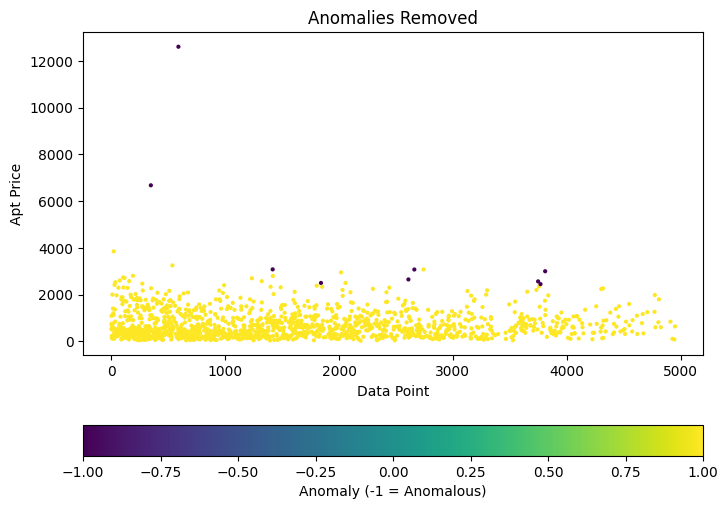

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(data_clean.index, data_clean['apt_1bed_center'], s=4,
            c=data_clean['anomaly'])
plt.ylabel('Apt Price')
plt.xlabel('Data Point')
plt.title('Anomalies Removed')
plt.colorbar(label='Anomaly (-1 = Anomalous)', orientation='horizontal')

We drop these outliers from the dataset. Also, before training, let's drop the city and country features since there are many unique categorical values for these features, and we are more concerned with the actual prices of items rather than predicting based on country or city. Finally, let's drop the **"data_quality"** column, since it has no effect on our actual data.

In [ ]:
data_clean = data_clean[data_clean['anomaly'] != -1]
data_clean = data_clean.drop(['anomaly_scores', 'anomaly',
                              'city', 'country', 'data_quality'], axis=1)

#Naive Bayes Model


In the Naive Bayes mode, we computed a log transformation on label values to apply a normaly distribution to the y values. Most of the y-values fall within a certain range that was encompassed mostly within 1 bin despite variations in total bin sizes. transform y into log y since y is not a normal distribution.It is recommended there is atleast 10 members per bin but we had two instances of bins with only 3 and 1 members. When we tested the naive bayes model by binning the y values (one-bedroom apartment prices in the city) into 3, 5 and 10 bins and performing cross validation, binning the labels into 3 values perf0rmed better with an average score of 70.5% compared to labels binned into 5 and 10 bins with average accuracies of 65.7% and 50%. This is indicates that it is harder to predict which price range a one-bedroom partment will be classified as when the range is small.




In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer

X = data_clean.drop('apt_1bed_center', axis=1)
y = data_clean['apt_1bed_center']
y_transformed = np.log(y)
y_transformed = y_transformed.to_numpy()

# Reshape y_array into a column vector
y_array_reshaped = y_transformed.reshape(-1, 1)

# Create a discretizer object with 3, 5 and 10 bins
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
discretizer2 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
discretizer3 = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Fit and transform the target variable y
y_discrete = discretizer.fit_transform(y_array_reshaped)
y_discrete2 = discretizer2.fit_transform(y_array_reshaped)
y_discrete3 = discretizer3.fit_transform(y_array_reshaped)

# Convert the output back to a 1D array
y_discrete = y_discrete.ravel()
y_discrete2 = y_discrete2.ravel()
y_discrete3 = y_discrete3.ravel()


# Create naives bayes model
naive_bayes = GaussianNB()
features = X

#Cross Validation
scores = cross_val_score(naive_bayes,X=features,y=y_discrete, cv = 10)
scores2 = cross_val_score(naive_bayes,X=features,y=y_discrete2, cv = 10)
scores3 = cross_val_score(naive_bayes,X=features,y=y_discrete3, cv = 10)

print("Accuracy with 3 bins:", scores.mean())
print("Accuracy with 5 bins:", scores2.mean())
print("Accuracy with 10 bins:", scores3.mean())

Accuracy with 3 bins: 0.7419089002097692
Accuracy with 5 bins: 0.6242033762860852
Accuracy with 10 bins: 0.4337428828288882


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


It seems evident that the highest accuracy is one where you have to predict with the least number of bins. We fit the naive bayes classifiers to the various bins and print utilize the predict function to make a classification report.

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

naive_bayes_3 = naive_bayes.fit(X = features, y = y_discrete)
naive_bayes_5 = naive_bayes.fit(X = features, y = y_discrete2)
naive_bayes_10 = naive_bayes.fit(X = features, y = y_discrete3)

naive_bayes_predict = cross_val_predict(naive_bayes,X=features,y=y_discrete, cv = 10)
print("Confusion Matrix with 3 bins:")
print(confusion_matrix(y_discrete, naive_bayes_predict))
print("Classification Report with 3 bins:")
print(classification_report(y_discrete, naive_bayes_predict))

naive_bayes_predict2 = cross_val_predict(naive_bayes,X=features,y=y_discrete2, cv = 10)
print("Confusion Matrix with 5 bins:")
print(confusion_matrix(y_discrete2, naive_bayes_predict2))
print("Classification Report with 5 bins:")
print(classification_report(y_discrete2, naive_bayes_predict2))

naive_bayes_predict3 = cross_val_predict(naive_bayes,X=features,y=y_discrete3, cv = 10)
print("Confusion Matrix with 10 bins:")
print(confusion_matrix(y_discrete2, naive_bayes_predict3))
print("Classification Report with 10 bins:")
print(classification_report(y_discrete2, naive_bayes_predict3))

Confusion Matrix with 3 bins:
[[105   9   1]
 [169 507 137]
 [  0  50 440]]
Classification Report with 3 bins:
              precision    recall  f1-score   support

         0.0       0.38      0.91      0.54       115
         1.0       0.90      0.62      0.74       813
         2.0       0.76      0.90      0.82       490

    accuracy                           0.74      1418
   macro avg       0.68      0.81      0.70      1418
weighted avg       0.81      0.74      0.75      1418

Confusion Matrix with 5 bins:
[[ 20   6   0   0   0]
 [ 72  91  28   1   1]
 [ 10 122 302  58   5]
 [  0   3 114 344  88]
 [  0   0   1  24 128]]
Classification Report with 5 bins:
              precision    recall  f1-score   support

         0.0       0.20      0.77      0.31        26
         1.0       0.41      0.47      0.44       193
         2.0       0.68      0.61      0.64       497
         3.0       0.81      0.63      0.70       549
         4.0       0.58      0.84      0.68       153

 

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_d

The roc_curve function does not support multiclass classification. Since there are more than two classes/bins we cannot use roc_curve directly.One possible solution is to use the One-vs-Rest (OvR) strategy to convert the multiclass problem into several binary classification problems. In OvR, for each class, a binary classifier is trained to distinguish samples belonging to that class from the rest of the samples. Then, the outputs of these binary classifiers can be used to compute the ROC curve and AUC for each class.

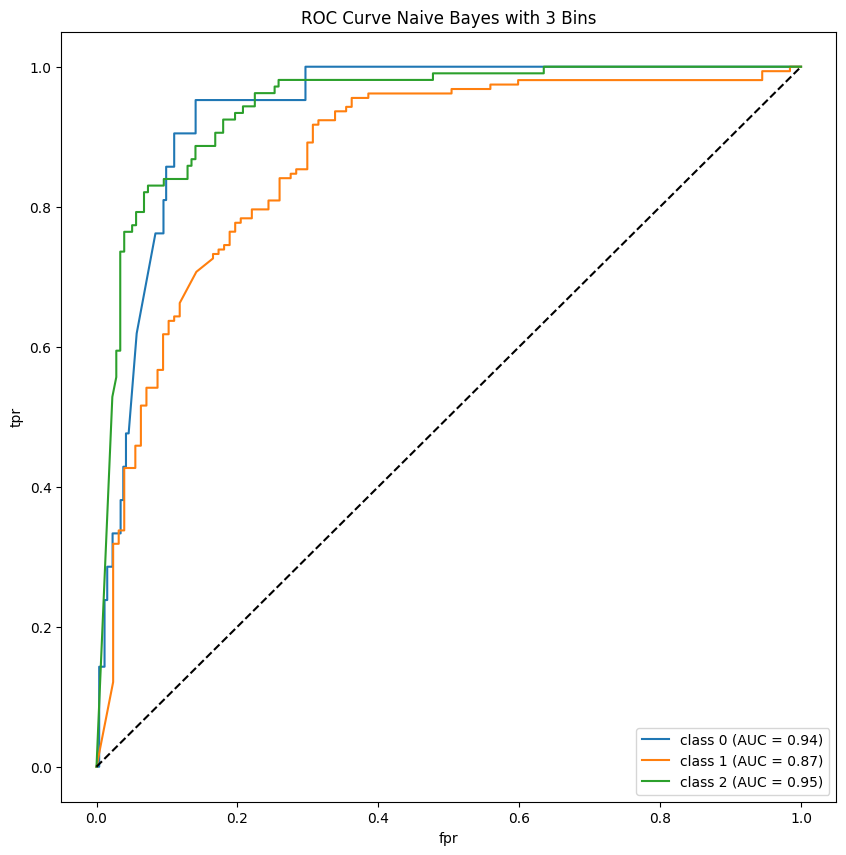

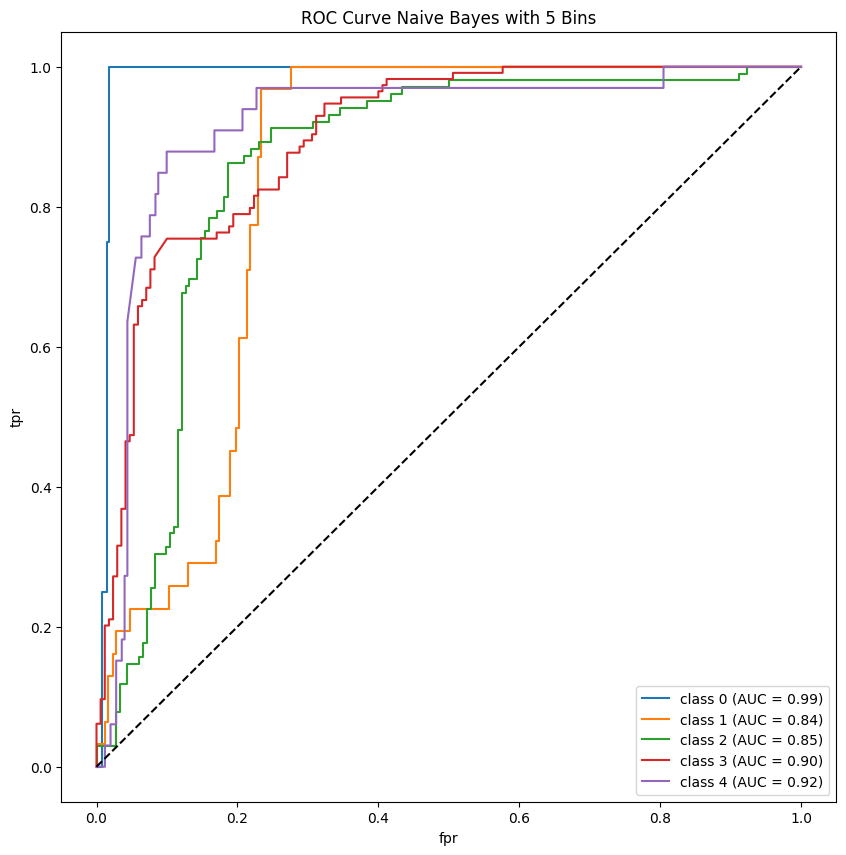

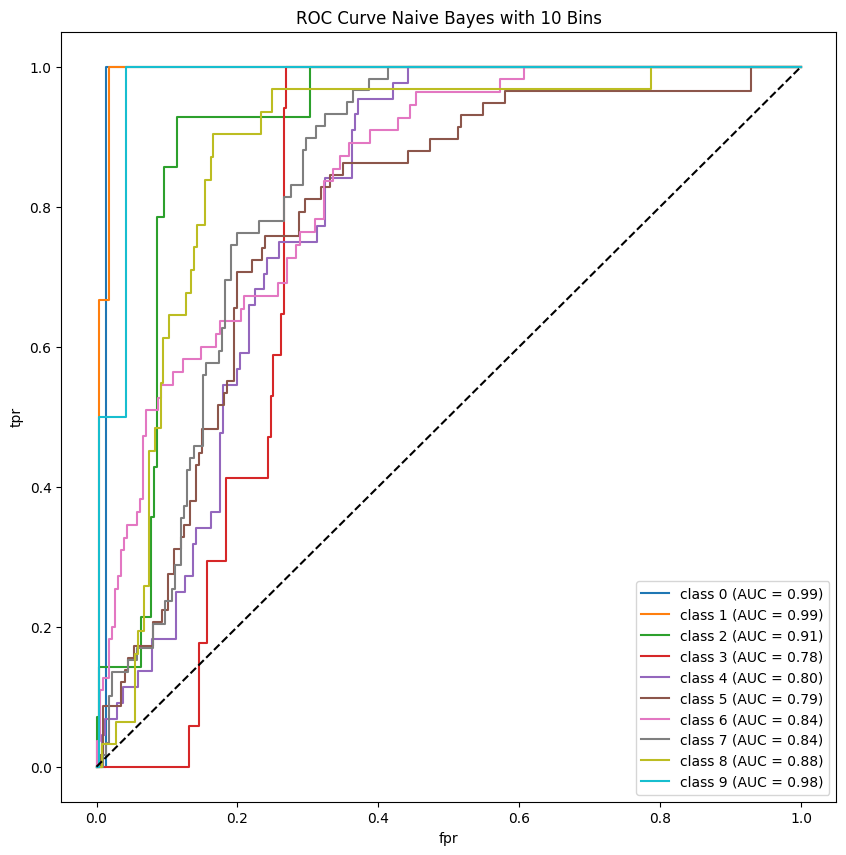

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

#separate test and training data
test_train3 = train_test_split(features, y_discrete, test_size=.2, train_size=.8, random_state = 33)
test_train5 = train_test_split(features, y_discrete2, test_size=.2, train_size=.8, random_state = 33)
test_train10 = train_test_split(features, y_discrete3, test_size=.2, train_size=.8, random_state = 33)

# create a One-vs-Rest classifier with GaussianNB as the base classifier
ovr_nb3 = OneVsRestClassifier(GaussianNB())
ovr_nb5 = OneVsRestClassifier(GaussianNB())
ovr_nb10 = OneVsRestClassifier(GaussianNB())
# fit the One-vs-Rest classifier on the training data
ovr_nb3.fit(test_train3[0], test_train3[2])
ovr_nb5.fit(test_train5[0], test_train5[2])
ovr_nb10.fit(test_train10[0], test_train10[2])

# predict the probabilities for each class using the One-vs-Rest classifier
probabilities3 = ovr_nb3.predict_proba(test_train3[1])
probabilities5 = ovr_nb5.predict_proba(test_train5[1])
probabilities10 = ovr_nb10.predict_proba(test_train10[1])

# compute the ROC curve and AUC for each class
fpr3 = dict()
tpr3 = dict()
auc3 = dict()
for i in range(len(ovr_nb3.classes_)):
    fpr3[i], tpr3[i], _ = roc_curve(test_train3[3], probabilities3[:, i], pos_label=i)
    auc3[i] = roc_auc_score(test_train3[3] == i, probabilities3[:, i])

fpr5 = dict()
tpr5 = dict()
auc5 = dict()
for i in range(len(ovr_nb5.classes_)):
    fpr5[i], tpr5[i], _ = roc_curve(test_train5[3], probabilities5[:, i], pos_label=i)
    auc5[i] = roc_auc_score(test_train5[3] == i, probabilities5[:, i])

fpr10 = dict()
tpr10 = dict()
auc10 = dict()
for i in range(len(ovr_nb10.classes_)):
    fpr10[i], tpr10[i], _ = roc_curve(test_train10[3], probabilities10[:, i], pos_label=i)
    auc10[i] = roc_auc_score(test_train10[3] == i, probabilities10[:, i])

for i in range(len(ovr_nb3.classes_)):
    plt.plot(fpr3[i], tpr3[i], label=f'class {i} (AUC = {auc3[i]:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes with 3 Bins')
plt.legend(loc='lower right')
plt.show()

for i in range(len(ovr_nb5.classes_)):
    plt.plot(fpr5[i], tpr5[i], label=f'class {i} (AUC = {auc5[i]:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes with 5 Bins')
plt.legend(loc='lower right')
plt.show()

for i in range(len(ovr_nb10.classes_)):
    plt.plot(fpr10[i], tpr10[i], label=f'class {i} (AUC = {auc10[i]:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes with 10 Bins')
plt.legend(loc='lower right')
plt.show()



# Random Over Sampler
Instead of manually transforming the data to make up for class imbalance, let's utilize the ROS package and bin the range into 5 groups. This duplicates minority class records. With ROS, we see a 10% increase in accuracy of the classifier and through cross validation as opposed to manually transforming the data.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import RandomOverSampler

# Instantiate and fit Random Over Sampler object
ros = RandomOverSampler()
y_whole = np.round(y).astype(int)
X_resampled, y_resampled = ros.fit_resample(X, y_whole)

y_whole = y_resampled.to_numpy().reshape(-1,1)
# Discretize both the training and testing sets
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
discretizer_ytrain = discretizer.fit_transform(y_whole)
discretizer_ytrain = discretizer_ytrain.ravel()

naive_bayes0 = GaussianNB()
features = X_resampled
scores_0 = cross_val_score(naive_bayes0,X=features,y=discretizer_ytrain, cv = 10)
print("Cross Validation Accuracy with 5 bins:", scores_0.mean())




Cross Validation Accuracy with 5 bins: 0.7435353535353535


[0. 1. 2.]
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([  3,  23,  59, 134, 217, 280, 291, 258, 134,  19]))


(array([  3.,  23.,  59., 134., 217., 280., 291., 258., 134.,  19.]),
 array([3.30027146, 3.79586637, 4.29146128, 4.78705619, 5.2826511 ,
        5.77824601, 6.27384092, 6.76943583, 7.26503074, 7.76062565,
        8.25622056]),
 <BarContainer object of 10 artists>)

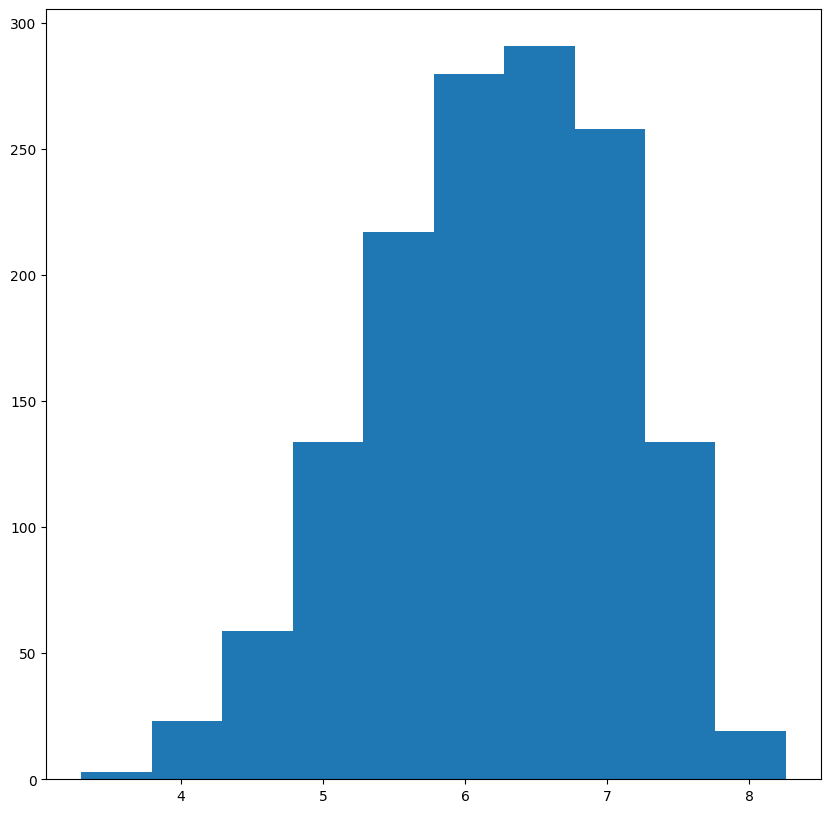

In [ ]:
from numpy.lib.histograms import histogram
print(np.unique(test_train3[2]))
print(np.unique(y_discrete3, return_counts= True))
plt.hist(np.log(y))

#K Nearest Neighbors

The knn pipeline is built using the StandardScaler and PCA classes from sklearn.preprocessing and the KNeighborsClassifier class from sklearn.neighbors.
The code then defines a parameter grid using the param_grid dictionary that contains the hyperparameters for PCA and KNeighborsClassifier. It specifies the number of components to keep after PCA and the number of neighbors to use for k-NN. Afterwards, a grid search is utilized to find the best hyperparameters for the pipeline. The following cell involves knn with binning of 5 and ROS data. With the optimal number of bins and ROS data, the best number of neighbors is 1 with an accuracy of 98% however this is likely due to overfitting.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
pca = PCA(svd_solver = 'full')
knn = KNeighborsClassifier()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])

param_grid = {
    'pca__n_components': [0.7, 0.8, 0.9, 0.95],
    'knn__n_neighbors': list(range(1, 25))
}

grid_search5 = GridSearchCV(pipeline, param_grid, cv=5)
grid_search5.fit(features, discretizer_ytrain)

print("Best number of dimensions with 5 bins:", grid_search5.best_params_['pca__n_components'])
print("Best number of neighbors with 5 bins:", grid_search5.best_params_['knn__n_neighbors'])
print("Best accuracy with 5 bins:", grid_search5.best_score_)

Best number of dimensions with 5 bins: 0.9
Best number of neighbors with 5 bins: 1
Best accuracy with 5 bins: 0.9802020202020202


When we perform knn for 3, 5 and 10 bins without ROS, we get significantly lower accuracy scores with an almost 30% decrease.

In [ ]:
scores = cross_val_score(pipeline, X, y_discrete, cv=5)
print("Accuracy for 3 discrete bins:  ", scores.mean())

scores2 = cross_val_score(pipeline, X, y_discrete2, cv=5)
print("Accuracy for 5 discrete bins:  ", scores2.mean())

scores3 = cross_val_score(pipeline, X, y_discrete3, cv=5)
print("Accuracy for 10 discrete bins:  ", scores3.mean())

Accuracy for 3 discrete bins:   0.8130766933758025
Accuracy for 5 discrete bins:   0.7002861693126958


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for 10 discrete bins:   0.4485691534365202


#KNN Without Binning
We had to bin in the Naive Bayes model but let's try KNN without binning. When we do a knn regressor with ROS, we don't get accuracies as high as knn with binning wih the best number of beighbors = 7 and an accuracy of 59%

In [ ]:
# grid_search_0 = GridSearchCV(pipeline, param_grid, cv=5)
# grid_search_0.fit(features, y)
# print("Best number of dimensions with 3 bins:", grid_search_0.best_params_['pca__n_components'])
# print("Best number of neighbors with 3 bins:", grid_search_0.best_params_['knn__n_neighbors'])
# print("Best accuracy with 3 bins:", grid_search_0.best_score_)
# scores0 = cross_val_score(pipeline, X, y_whole, cv=5)
# print("Accuracy for 5 discrete bins:  ", scores0.mean())

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

for n in range(1, 11):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores = cross_val_score(knn, X, y, cv=5)
    print("KNN without binning with", n, "neightbors:", scores.mean())



KNN without binning with 1 neightbors: 0.37827629264410084
KNN without binning with 2 neightbors: 0.5295079223890045
KNN without binning with 3 neightbors: 0.5533077602046508
KNN without binning with 4 neightbors: 0.5715379948095289
KNN without binning with 5 neightbors: 0.582534712653397
KNN without binning with 6 neightbors: 0.5895135174331039
KNN without binning with 7 neightbors: 0.5889554874206887
KNN without binning with 8 neightbors: 0.5847246742521736
KNN without binning with 9 neightbors: 0.5826994146603376
KNN without binning with 10 neightbors: 0.5865980752478798


# **Support Vector Regression**

To build the svr model, we used a pipeline using the StandardScaler and PCA classes again. Using a parameter grid that adjusts the hyperparameters for PCA and SVR to find the optimal values. We then use cross_val_predict to perform nested cross validation.

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict


scaler = StandardScaler()
pca = PCA()
svr = SVR()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svr', svr)])
param_grid = {
    'pca__n_components': list(range(5, 47)),
    'svr__kernel': ['linear', 'rbf', 'poly']
}

oned_y = np.ravel(y)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, error_score='raise')
grid_search.fit(X, oned_y)
print("Best number of dimensions: ", grid_search.best_params_['pca__n_components'])
print("Best kernel type: ", grid_search.best_params_['svr__kernel'])
pred = cross_val_predict(grid_search, X, oned_y, cv=5)
mse = mean_squared_error(y, pred)
r2 = r2_score(y, pred)
print("Mean Squared Error: ", mse)
print("R-Squared: ", r2)

Best number of dimensions:  46
Best kernel type:  linear


NameError: ignored

Using the optimal hyperparameters we found above, lets visualize our model by looking at the SVR with a few different features.

In [ ]:
xscaler = StandardScaler()
yscaler = StandardScaler()
cap = data_clean[['capuccino']]
cap = xscaler.fit_transform(cap)
y = yscaler.fit_transform(y)
svr = SVR(kernel='linear')
svr.fit(cap, y)

plt.scatter(cap, y, color = 'red')
plt.plot(cap, svr.predict(cap), color = 'blue')
plt.title('Support Vector Regression Model')
plt.xlabel('Price of a capuccino (scaled)')
plt.ylabel('Price of a 1 bedroom apartment (scaled)')
plt.show()

toyota = data_clean[['toyota_new']]
toyota = xscaler.fit_transform(toyota)
svr.fit(toyota, y)

plt.scatter(toyota, y, color = 'red')
plt.plot(toyota, svr.predict(toyota), color = 'blue')
plt.title('Support Vector Regression Model')
plt.xlabel('Price of a new toyota (scaled)')
plt.ylabel('Price of a 1 bedroom apartment (scaled)')
plt.show()

eggs = data_clean[['eggs']]
eggs = xscaler.fit_transform(eggs)
svr.fit(eggs, y)

plt.scatter(eggs, y, color = 'red')
plt.plot(eggs, svr.predict(eggs), color = 'blue')
plt.title('Support Vector Regression Model')
plt.xlabel('Price of eggs (scaled)')
plt.ylabel('Price of a 1 bedroom apartment (scaled)')
plt.show()

# SVC

Our labels are continous, meaning that we had to use SVR instead of SVC with the original data. Let's see how using binning to turn this into a classification problem changes things.

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

y_transformed = np.log(y)
y_transformed = y_transformed.to_numpy()

# Reshape y_array into a column vector
y_array_reshaped = y_transformed.reshape(-1, 1)

# Create a discretizer object with 3, 5 and 10 bins
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
discretizer2 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
discretizer3 = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Fit and transform the target variable y
y_discrete = discretizer.fit_transform(y_array_reshaped)
y_discrete2 = discretizer2.fit_transform(y_array_reshaped)
y_discrete3 = discretizer3.fit_transform(y_array_reshaped)

# Convert the output back to a 1D array
y_discrete = y_discrete.ravel()
y_discrete2 = y_discrete2.ravel()
y_discrete3 = y_discrete3.ravel()


# Create naives bayes model
svc = SVC()
features = X

#Cross Validation
scores = cross_val_score(svc, X=features, y=y_discrete, cv = 10)
scores2 = cross_val_score(svc, X=features, y=y_discrete2, cv = 10)
scores3 = cross_val_score(svc,X=features,y=y_discrete3, cv = 10)

print("Accuracy with 3 bins:", scores.mean())
print("Accuracy with 5 bins:", scores2.mean())
print("Accuracy with 10 bins:", scores3.mean())

Once again, we find that using a smaller amount of bins results in a more accurate classifier.

# Linear Regression

The code imports the necessary libraries, including pandas for data manipulation and Linear Regression, train_test_split and RFE for feature selection. The data is split into training and testing sets, and the RFE (Recursive Feature Elimination) method is used to select the top five features that are most relevant to the target variable (rent). The RFE method works by recursively removing the least important feature and fitting the model again until the desired number of features is reached.

In [ ]:
#LINEAR REGRESSION

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

X_ln = data_clean.drop('apt_1bed_center', axis=1)
y_ln = data_clean['apt_1bed_center']
X_train_ln, X_test_ln, y_train_ln, y_test_ln = train_test_split(X_ln, y_ln, test_size=0.2, random_state=42)

model = LinearRegression()

rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_train_ln, y_train_ln)

print("Feature ranking:", rfe.ranking_)

ranking = rfe.ranking_


feature_ranking = {}
for i in range(len(X_ln.columns)):
    feature_ranking[X_ln.columns[i]] = ranking[i]

sorted_features = sorted(feature_ranking.items(), key=lambda x: x[1])
print("sorted features ", sorted_features)

for feature, rank in sorted_features:
    print(f"{feature}: {rank}")

The code keeps track of the highest R-squared value and the best set of features found so far. The best_features list is updated with the best set of features found in each iteration, and the highest_r_squared variable is updated with the highest R-squared value found.

Overall, this code is an example of a systematic approach to feature selection using the RFE method and a Linear Regression model. The resulting set of features can then be used to build a more accurate predictive model.

In [ ]:
X_train_ln, X_test_ln, y_train_ln, y_test_ln = train_test_split(X_ln, y_ln, test_size=0.2, random_state=42)

highest_r_squared = 0.0
best_features = []

while len(X_train_ln.columns) > 4:
    model = LinearRegression()

    rfe = RFE(model, n_features_to_select=5)
    rfe.fit(X_train_ln, y_train_ln)

    print("Feature ranking:", rfe.ranking_)

    ranking = rfe.ranking_

    feature_ranking = {}
    for i in range(len(X_train_ln.columns)):
        feature_ranking[X_train_ln.columns[i]] = ranking[i]

    sorted_features = sorted(feature_ranking.items(), key=lambda x: x[1])

    best_features_for_iteration = [sorted_features[i][0] for i in range(5)]

    model.fit(X_train_ln[best_features_for_iteration], y_train_ln)
    r_squared = model.score(X_test_ln[best_features_for_iteration], y_test_ln)

    if r_squared > highest_r_squared:
        highest_r_squared = r_squared
        best_features = best_features_for_iteration

    print("Best features for iteration:", best_features_for_iteration)
    print("R-squared for iteration:", r_squared)
    print("Current best features:", best_features)
    print("Current highest R-squared:", highest_r_squared)
    print("")

    X_train_ln = X_train_ln.drop(best_features_for_iteration, axis=1)
    X_test_ln = X_test_ln.drop(best_features_for_iteration, axis=1)



In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_ln = data_clean.drop('apt_1bed_center', axis=1)
y_ln = data_clean['apt_1bed_center']

r2_scores = []

for train_index, test_index in kf.split(X_ln):

    X_train_ln, X_test_ln = X_ln.iloc[train_index], X_ln.iloc[test_index]
    y_train_ln, y_test_ln = y_ln.iloc[train_index], y_ln.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train_ln, y_train_ln)

    y_pred_ln = model.predict(X_test_ln)
    r2 = r2_score(y_test_ln, y_pred_ln)
    print(" R-squared value: ", r2)

    r2_scores.append(r2)

print("Average R-squared value:", np.mean(r2_scores))


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

scaler = StandardScaler()
lin_reg = LinearRegression()


pipeline = Pipeline(steps=[('scaler', scaler), ('lin_reg', lin_reg)])

param_grid = {
    'lin_reg__fit_intercept': [True, False],
    'lin_reg__copy_X': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_ln, y_ln)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_ln = best_model.predict(X_ln)
r2 = r2_score(y_ln, y_pred_ln)
print("Train R-squared:", r2)


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

median_rent = data_clean['apt_1bed_center'].median()
data_clean['above_median_rent'] = (data_clean['apt_1bed_center'] > median_rent).astype(int)

# Split the data into training and testing sets
X_reg = data_clean.drop(['above_median_rent'], axis=1)
y_reg = data_clean['above_median_rent']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train_reg, y_train_reg)

# Evaluate the model on the testing set
y_pred_reg = clf.predict(X_test_reg)
accuracy = accuracy_score(y_test_reg, y_pred_reg)
print(f"Accuracy: {accuracy}")

The accuracy is too high for Logistic Regression. An accuracy that is too high could be a sign of overfitting. Overfitting occurs when a model is too complex and fits the training data too closely, leading to poor performance on unseen data. In the case of a logistic regression model, an accuracy that is too high could mean that the model is relying too much on the training data and is not generalizing well to new data. This can be problematic because the model may not perform well on real-world data that it was not trained on.

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

median_rent = data_clean['apt_1bed_center'].median()
data_clean['above_median_rent'] = (data_clean['apt_1bed_center'] > median_rent).astype(int)

X_reg = data_clean.drop(['above_median_rent'], axis=1)
y_reg = data_clean['above_median_rent']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, X_train_reg, y_train_reg, cv=5)
print(f"Cross validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

clf.fit(X_train_reg, y_train_reg)
y_pred_reg = clf.predict(X_test_reg)
accuracy = accuracy_score(y_test_reg, y_pred_reg)
print(f"Accuracy on testing data: {accuracy}")


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Define the logistic regression model
clf = LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs')

# Perform k-fold cross-validation
cv_scores_train = cross_val_score(clf, X_train_reg, y_train_reg, cv=5, scoring='accuracy')
cv_scores_test = cross_val_score(clf, X_test_reg, y_test_reg, cv=5, scoring='accuracy')

# Calculate the average train and test scores
train_score = np.mean(cv_scores_train)
test_score = np.mean(cv_scores_test)

# Print the scores
print(f"Average train score: {train_score}")
print(f"Average test score: {test_score}")
